<h2>Streaming clustering for anomaly detection</h2>

<h3>Problem formulation</h3>

In this notebook, we focus on the problem of unsupervised anomaly detection in the data produced by the ADXL accelerometer mounted at the small Intel CPU fan. The task is to train a model of normal behavior which can be used in order to classify anomalous events that significantly deviate from the norms described by the model. The normal behavior includes two main patterns: idle and active. These patterns are generated by periodically switching the fan on, letting it rotate for some time and then shutting it down. Examples of anomalous events include:
<ul>
  <li>"Shake" - shaking the table on which the fan is located when the fan is active</li>
  <li>"Tape" - attaching a small piece of tape on one of the fan blades and switching the fan on</li>
  <li>"Stick" - poking a plastic stick into the blades when the fan is active</li>
</ul>

We aim to build the normal behavior model as a set of clusters. This would allow us calssify a new unlabeled input sample based on the distance between this sample and the clusters found: if this distance is above some predefined threshold, the sample is labeled as an anomaly. The resulting code is supposed to be able to run on a small IoT board such as Arduino UNO. This imposes computing and memory constraints which a solution of the problem formulated should satisfy. In particular, due to low amount of RAM, there is no possibility to keep many data samples in memory, and therefore a streaming clustering algorithm should be empoyed. Furthermore, the maximum number of clusters is also limited. Finally, there is need for a low-complexity method to compare several clustering methods to each other in terms of anomaly detection accuracy. Since there is no any information about anomalies during the training, this method should rely solely on the normal data.

<img src="figures/fan/env.jpg" alt="Environment" width="700">

<h3>Data preprocessing</h3>

Import packages needed:

In [1]:
import os
import numpy as np
import pandas as pd
import os.path as osp

from sklearn.manifold import TSNE
from matplotlib import pyplot as pp
from ctypes import cdll, c_short, POINTER
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.cluster import KMeans

Specify the task parameters:

In [2]:
np.random.seed(0)  # random seed for results reproducability
series_len = 32  # the length of the time series to sample
dataset_file_offset = 11  # skip few first samples
n_test = 4000  # number of test points from each class

Feature extraction functions:
<ul style="list-style-type:circle">
  <li>simple_features: min, max, mean and std of each component in the time-series</li>
  <li>fft_features: few main frequency components of each component in the time-series</li>
</ul>

In [3]:
def simple_features(X):
    assert len(X.shape) == 3
    m = X.shape[2]
    I = np.ones((m, m))
    I[np.triu_indices(m)] = 0
    E = np.vstack([
        np.hstack([
            np.min(x, 0),
            np.max(x, 0),
            np.mean(x, 0),
            np.std(x, 0),
        ]) for x in X
    ])    
    return E

def fix_fft(x, m=5, n_fft_features=16, fpath='libraries/fix_fft_32k_dll/fix_fft_32k.so'):
    ff = cdll.LoadLibrary(fpath)
    ff.fix_fft.argtypes = [POINTER(c_short), POINTER(c_short), c_short, c_short]
    n = x.shape[0]
    x = [np.array(x[:, i], dtype=int) for i in range(x.shape[1])]
    def fft(re):
        im = [0 for _ in range(n)]
        re_c = (c_short * n)(*re)
        im_c = (c_short * n)(*im)
        ff.fix_fft(re_c, im_c, c_short(m), c_short(0))
        s = np.zeros(n_fft_features)
        for i in range(n_fft_features):
            s[i] = np.round(np.sqrt(re_c[i] * re_c[i] + im_c[i] * im_c[i]) // 2)
        return s 
    mgn = map(fft, x)
    return np.transpose(np.vstack(mgn))

def fft_features(X):
    assert len(X.shape) == 3
    spectrogram = fix_fft(X[0, :, :])
    E = [fix_fft(x) for x in X]
    return simple_features(np.stack(E))

Load the data:

In [4]:
data_dir = 'data/adxl_fan'
subdirs = {}
subdirs['normal'] = ['on_off']
subdirs['anomaly'] = ['stick', 'tape', 'shake']
sample_subdirs = [subdir for subdir in os.listdir(data_dir) if osp.isdir(osp.join(data_dir, subdir)) and subdir in subdirs['normal'] + subdirs['anomaly']]
samples, labels = [], []
xmin, xmax = [], []
for sd in sample_subdirs:
    sample_files = os.listdir(osp.join(data_dir, sd))
    for sf in sample_files:
        fpath = osp.join(osp.join(data_dir, sd), sf)
        if osp.isfile(fpath) and fpath.endswith('.csv'):
            X = pd.read_csv(fpath, header=None).values
            if sd in subdirs['normal']:
                label = 'normal'
            else:
                label = sd
            if label not in labels:
                labels.append(label)
            samples.append(X)

print('Labels:', labels)
with open(f'{data_dir}/labels.txt', 'w')     as f:
    f.write(','.join(labels))

Labels: ['normal', 'shake', 'tape', 'stick']


Create the training and validation sets using the normal data only:

In [5]:
normal_behavior = labels.index('normal')
num_labels = len(labels)
anomalies = [i for i in range(num_labels) if i != normal_behavior]
n_anomalies = len(anomalies)
input_dim = samples[normal_behavior].shape[1]

inds = np.arange(dataset_file_offset, samples[normal_behavior].shape[0], 1)
tr_va, remaining = np.split(inds, [int(0.7 * len(inds))]) 
tr, va = np.split(tr_va, [int(0.7 * len(tr_va))])

X_tr, Y_tr = [], []
for i in tr:
    x = samples[normal_behavior][i : i + series_len, :]
    X_tr.append(x)
    Y_tr.append(0)
X_tr = np.array(X_tr)
Y_tr = np.hstack(Y_tr)

X_va, Y_va = [], []
for i in va:
    x = samples[normal_behavior][i : i + series_len, :]
    X_va.append(x)
    Y_va.append(0)
X_va = np.array(X_va)
Y_va = np.hstack(Y_va)

Create the test set using both the normal and anomalous data:

In [6]:
X_te, Y_te = [], []
for i in range(n_test):
    y = np.random.randint(0, num_labels)
    n = samples[y].shape[0]
    j = np.random.randint(dataset_file_offset, n - series_len)
    x = samples[y][j: j + series_len, :]
    X_te.append(x)
    Y_te.append(y)
X_te = np.array(X_te)
Y_te = np.hstack(Y_te)

Extract and standardize features:

In [7]:
extract_features = simple_features

E_tr = extract_features(X_tr)
E_va = extract_features(X_va)
E_te = extract_features(X_te)

ntr = E_tr.shape[0]
nte = len(Y_te)
xdim = E_tr.shape[1]

xmin = np.min(E_tr, 0)
xmax = np.max(E_tr, 0)
E_tr_ = (E_tr - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)
E_va_ = (E_va - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)
E_te_ = (E_te - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)

reals = np.zeros(nte)
reals[np.where(Y_te != normal_behavior)] = 1

<h3>K-means++ (non-streaming, baseline)</h3>

Clustering parameteres:

In [8]:
n_clusters_min = 2  # the minimum number of clusters
n_clusters_max = 7  # the maximum number of clusters

Clustering procedure:

In [9]:
kmeans, W_km = [], []
for n_clusters in range(n_clusters_min, n_clusters_max + 1):
    kmeans.append(KMeans(n_clusters=n_clusters, random_state=0).fit(E_tr_))
    W_km.append([len(np.where(kmeans[-1].labels_ == k)[0]) for k in np.unique(kmeans[-1].labels_)])

Apply <a href=https://lvdmaaten.github.io/tsne/>t-SNE</a> for dimensionality reduction:

In [10]:
all_centroids = np.vstack([km.cluster_centers_ * (xmax[None, :] - xmin[None, :]) + xmin[None, :] for km in kmeans])
X_plot = np.vstack([E_te, all_centroids])
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
xy_all = tsne.fit_transform(np.vstack(X_plot))
c_km = []
n = 0
for i in range(len(kmeans))[::-1]:
    ni = kmeans[i].cluster_centers_.shape[0]
    c_km.append(xy_all[-n - ni : xy_all.shape[0] - n])
c_km = c_km[::-1]

Plot test data points from each class and the cluster centroids found:

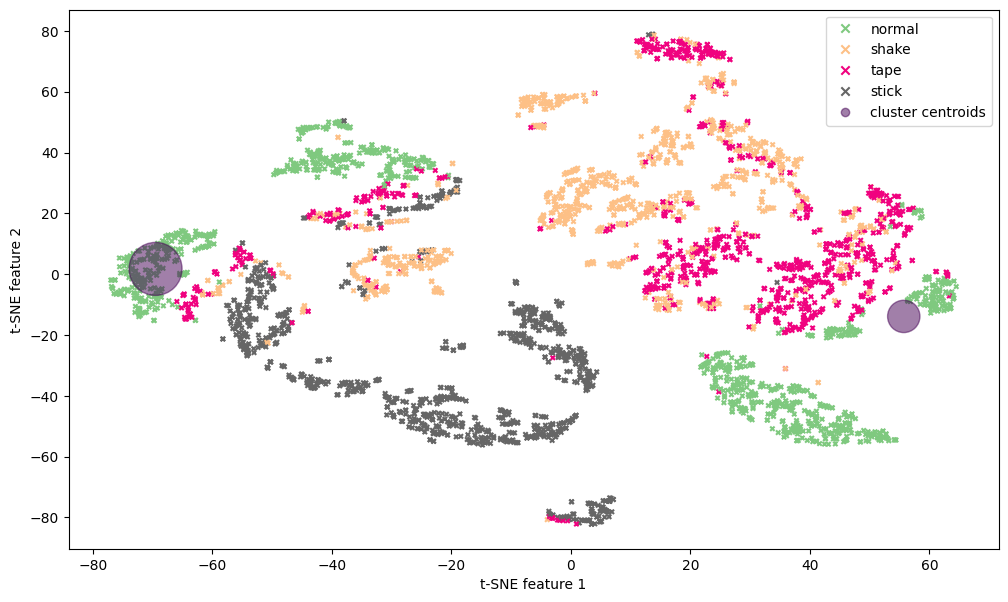

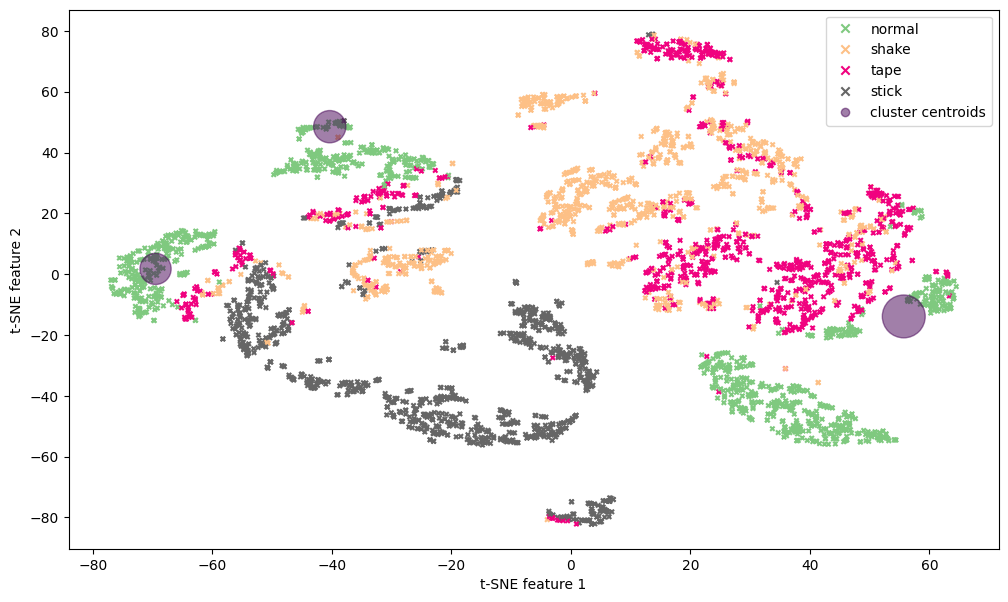

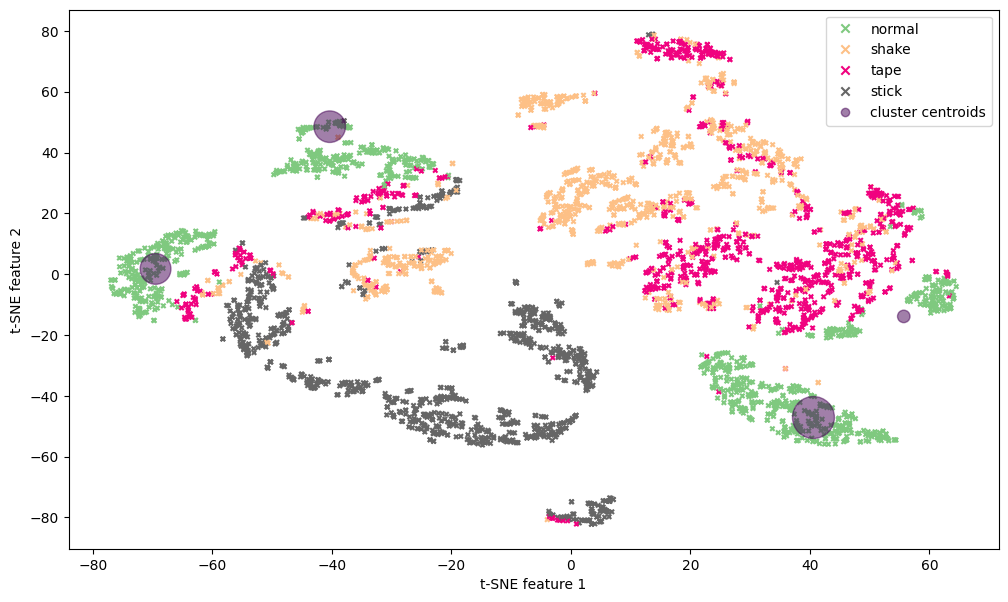

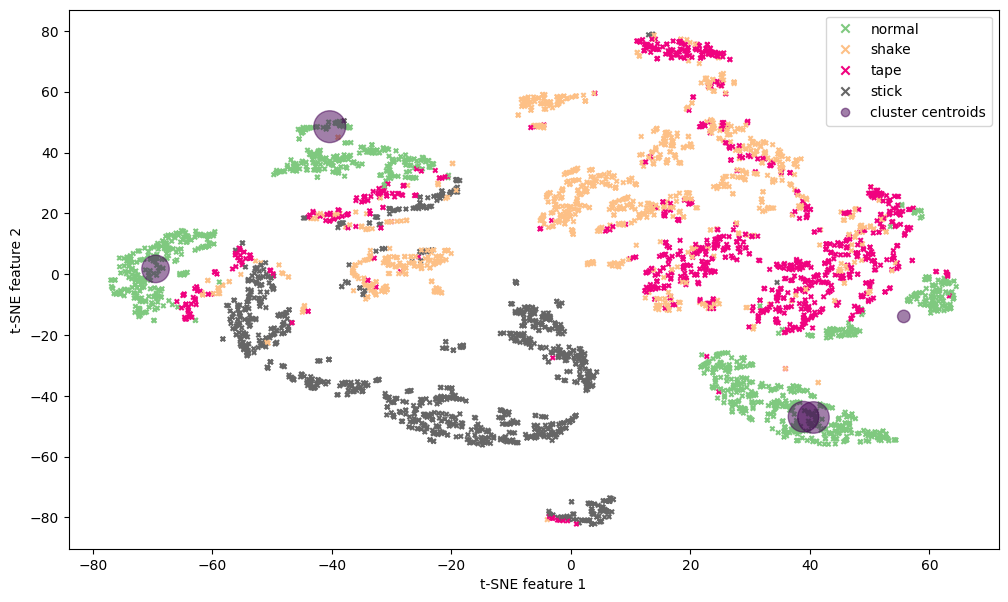

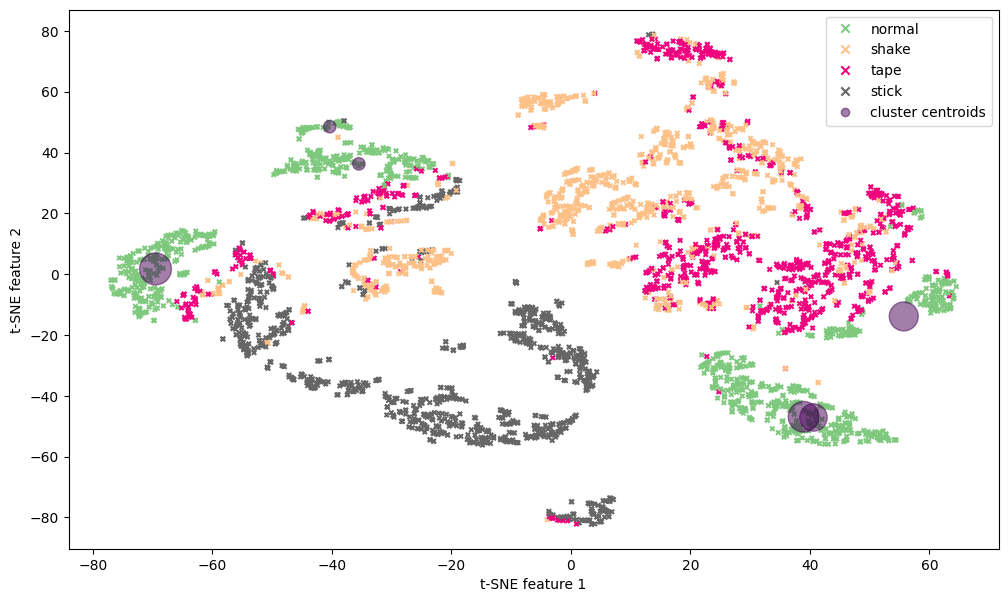

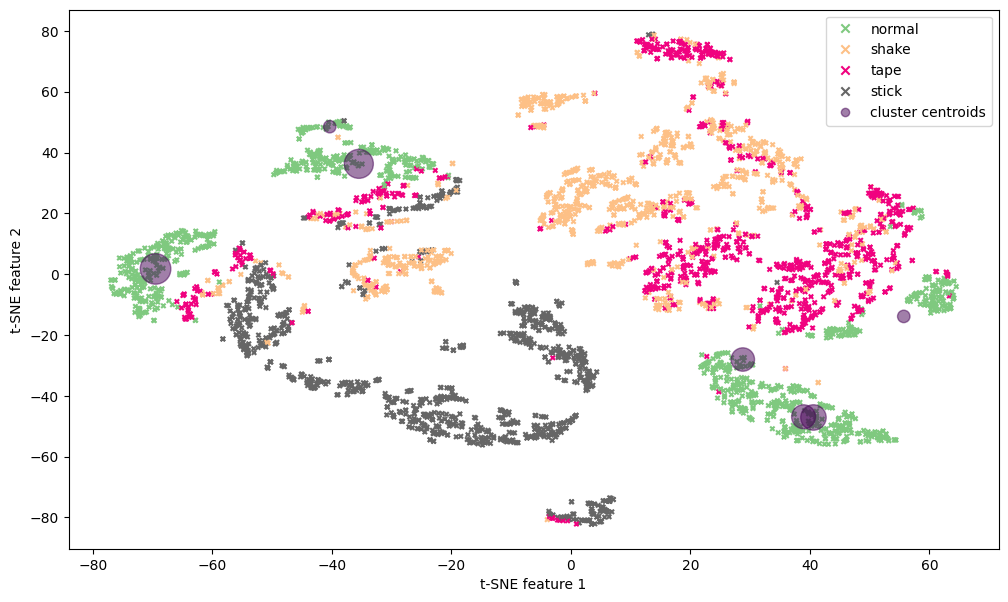

In [11]:
pp.style.use('default')
for c, w in zip(c_km, W_km):
    pp.figure(figsize=(12, 7))
    scatter_points = pp.scatter(xy_all[:-all_centroids.shape[0], 0], xy_all[:-all_centroids.shape[0], 1], c = Y_te, s = 10, cmap = 'Accent', marker='x')
    pp.xlabel('t-SNE feature 1',fontsize=10)
    pp.ylabel('t-SNE feature 2',fontsize=10)
    scatter_centroids = pp.scatter(c[:, 0], c[:, 1], c = np.zeros(c.shape[0]), s = w / np.sum(w) * 2000, alpha = 0.5);   
    pp.legend(
        scatter_points.legend_elements()[0] + scatter_centroids.legend_elements()[0], 
        labels + ['cluster centroids'], 
        loc = 0
    )
    pp.show()
    pp.close()

Calculate FPR, TPR, accuracy, and AUC for each number of clusters:

Number of clusters = 2, tpr = 81.433, fpr = 0.1, accuracy = 86.05, AUC = 0.88662
Number of clusters = 3, tpr = 84.3, fpr = 0.1, accuracy = 88.2, AUC = 0.90024
Number of clusters = 4, tpr = 90.367, fpr = 0.1, accuracy = 92.75, AUC = 0.92908
Number of clusters = 5, tpr = 90.367, fpr = 0.1, accuracy = 92.75, AUC = 0.92908
Number of clusters = 6, tpr = 92.667, fpr = 0.1, accuracy = 94.475, AUC = 0.94002
Number of clusters = 7, tpr = 92.667, fpr = 0.2, accuracy = 94.45, AUC = 0.9167


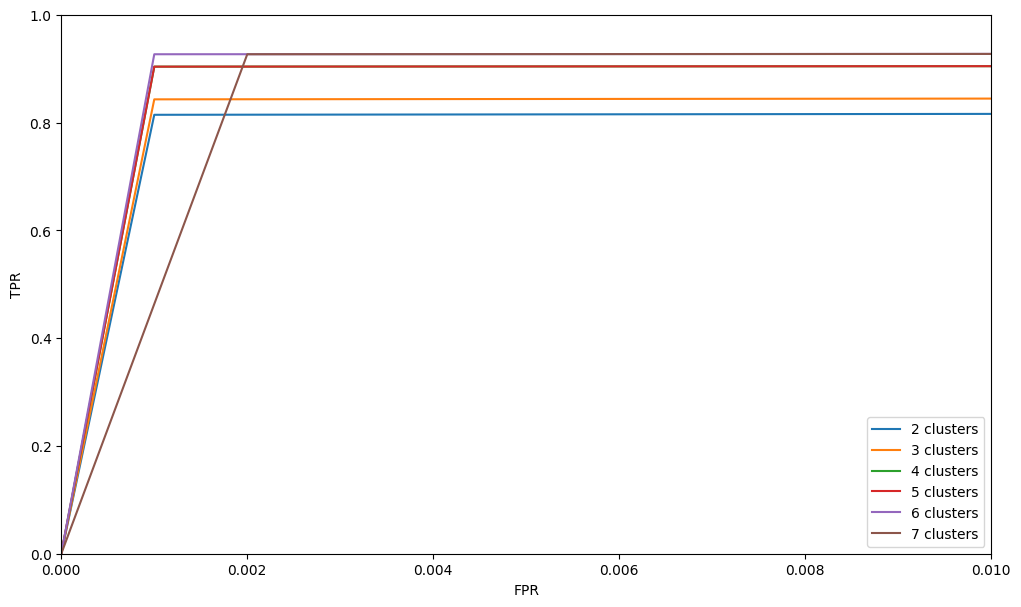

In [12]:
radiuses = []
fprs, tprs, accs, aucs = [], [], [], []

for ci, km in enumerate(kmeans):
    
    C_ = km.cluster_centers_
    
    D_va = np.linalg.norm(E_va_[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_va = np.argmin(D_va, axis=1)
    dists_va = np.min(D_va, axis=1)
    
    D_te = np.linalg.norm(E_te_[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_te = np.argmin(D_te, axis=1)
    dists_te = np.min(D_te, axis=1)
       
    fpr = 1
    alpha = 0
    alpha_max = 100
    alpha_step = 0.01
    
    dist_thrs = np.zeros(C_.shape[0])
    for k in range(C_.shape[0]):
        idx = np.where(cl_labels_va == k)[0]
        dist_thrs[k] = np.max(dists_va[idx])
    radiuses.append(dist_thrs)
    pred_thrs = dist_thrs[cl_labels_te]
    predictions = np.zeros(nte)
    predictions[np.where(dists_te > pred_thrs)[0]] = 1
    fpr, tpr, thresholds = roc_curve(reals, predictions)    
    fprs.append(fpr)
    tprs.append(tpr)
    fpr_ = len(np.where((predictions == 1) & (reals == 0))[0]) / (1e-10 + len(np.where(reals == 0)[0])) * 100
    tpr_ = len(np.where((predictions == 1) & (reals == 1))[0]) / (1e-10 + len(np.where(reals == 1)[0])) * 100
    acc = len(np.where(predictions == reals)[0]) / nte * 100
    auc_score = roc_auc_score(reals, predictions, max_fpr=0.01)
    accs.append(acc)
    aucs.append(auc_score)
    print(f'Number of clusters = {len(np.unique(km.labels_))}, tpr = {tpr_:.5}, fpr = {fpr_:.5}, accuracy = {acc:.5}, AUC = {auc_score:.5}')

pp.figure(figsize=(12,7))
for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
    pp.plot(np.array(fpr), np.array(tpr), label=f'{kmeans[i].cluster_centers_.shape[0]} {"cluster" if kmeans[i].cluster_centers_.shape[0] == 1 else "clusters"}')
pp.xlim([0, 0.01])
pp.ylim([0, 1])
pp.xlabel('FPR')
pp.ylabel('TPR')
pp.legend()
pp.show()
pp.close()

Metrics which can be calculated using normal data only, since in a real-life use-case we often do not have anomalous examples:
<ul> 
<li>Mass volume</li>
<li>Excess mass</li>
</ul>

In [13]:
def em(t, t_max, volume_support, s_unif, s_X, n_generated):
    EM_t = np.zeros(t.shape[0])
    n_samples = s_X.shape[0]
    s_X_unique = np.unique(s_X)
    EM_t[0] = 1.
    for u in s_X_unique:
        EM_t = np.maximum(EM_t, 1. / n_samples * (s_X > u).sum() - t * (s_unif > u).sum() / n_generated * volume_support)
    amax = np.argmax(EM_t <= t_max) + 1
    if amax == 1:
        amax = -1
    AUC = auc(t[:amax], EM_t[:amax])
    return AUC, EM_t, amax

def mv(axis_alpha, volume_support, s_unif, s_X, n_generated):
    n_samples = s_X.shape[0]
    s_X_argsort = s_X.argsort()
    mass = 0
    cpt = 0
    u = s_X[s_X_argsort[-1]]
    mv = np.zeros(axis_alpha.shape[0])
    for i in range(axis_alpha.shape[0]):
        while mass < axis_alpha[i]:
            cpt += 1
            u = s_X[s_X_argsort[-cpt]]
            mass = 1. / n_samples * cpt
        mv[i] = float((s_unif >= u).sum()) / n_generated * volume_support
    return auc(axis_alpha, mv), mv

Calculate MV and EM metrics:

In [14]:
em_rocs, mv_rocs = [], []
em_aucs, mv_aucs = [], []
ts = []

t_max = 0.99
n_generated = 100000
volume_support = (np.ones(E_va_.shape[1]) - np.zeros(E_va_.shape[1])).prod()
t = np.arange(0, 1 / volume_support, 0.001 / volume_support)
alpha_min = 0.99
alpha_max = 0.99999
axis_alpha = np.arange(alpha_min, alpha_max, 0.001)
X_unif = np.random.uniform(np.zeros(E_va_.shape[1]), np.ones(E_va_.shape[1]), size=(n_generated, E_va_.shape[1]))

for ci, km in enumerate(kmeans):
    
    C_ = km.cluster_centers_        

    D_test = np.linalg.norm(E_va_[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_test = np.argmin(D_test, axis=1)
    dists_test = np.min(D_test, axis=1)

    D_unif = np.linalg.norm(X_unif[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_unif = np.argmin(D_unif, axis=1)
    dists_unif = np.min(D_unif, axis=1)

    pred_thrs_test = radiuses[ci][cl_labels_test]
    predictions_test = (pred_thrs_test - dists_test) / (pred_thrs_test + 1e-10)

    pred_thrs_unif = radiuses[ci][cl_labels_unif]
    predictions_unif = (pred_thrs_unif - dists_unif) / (pred_thrs_unif + 1e-10)
    auc_em, em_roc, amax = em(t, t_max, volume_support, predictions_unif, predictions_test, n_generated)
    auc_mv, mv_roc = mv(axis_alpha, volume_support, predictions_unif, predictions_test, n_generated)
    mv_rocs.append(mv_roc)
    em_rocs.append(em_roc[:amax])
    mv_aucs.append(auc_mv)
    em_aucs.append(auc_em)
    ts.append(t[:amax])

Plot the metrics:

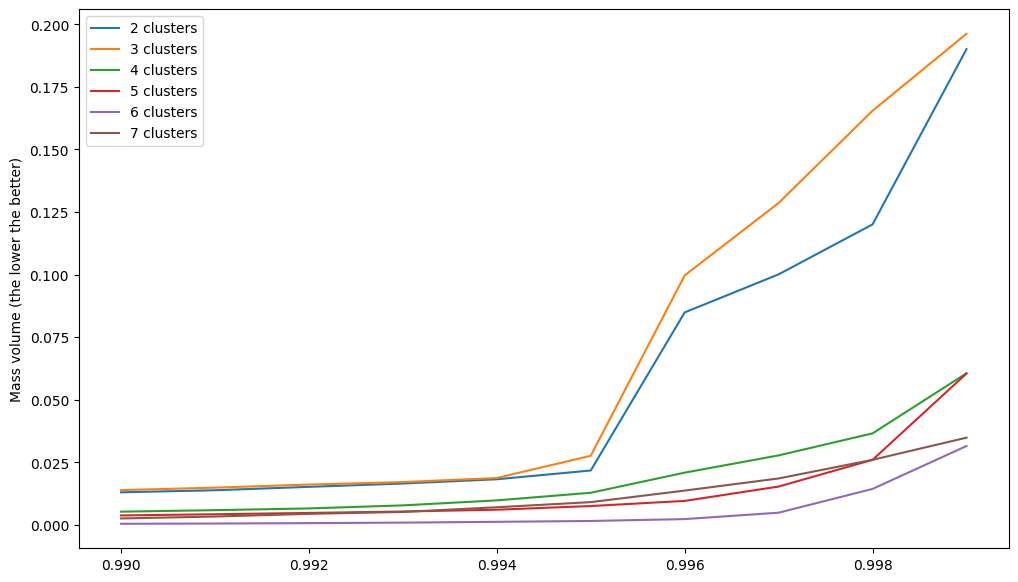

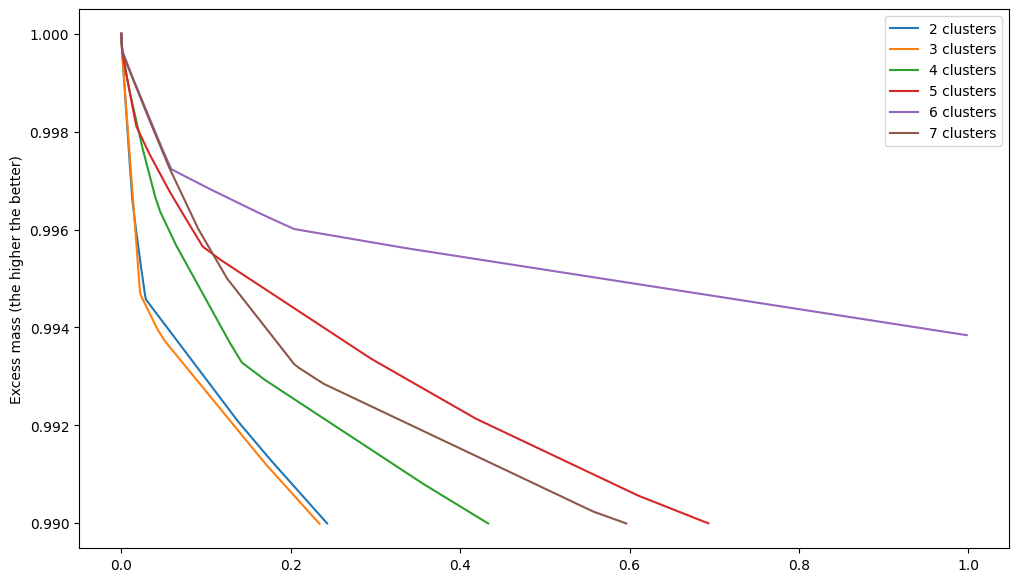

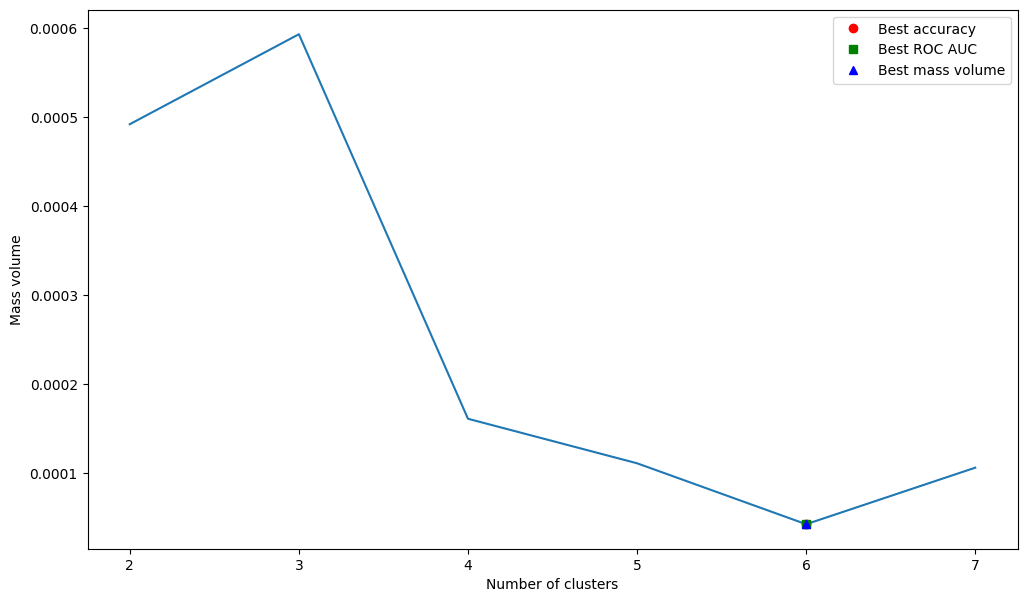

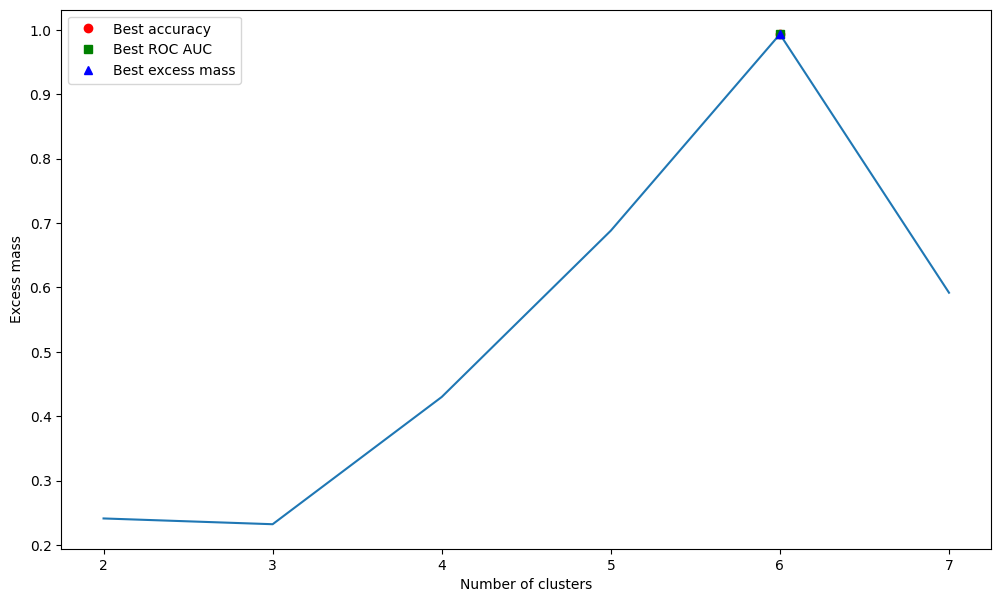

In [15]:
pp.figure(figsize=(12,7))
for i, mv_roc in enumerate(mv_rocs):
    pp.plot(axis_alpha, mv_roc, label=f'{kmeans[i].cluster_centers_.shape[0]} {"cluster" if kmeans[i].cluster_centers_.shape[0] == 1 else "clusters"}')
pp.ylabel('Mass volume (the lower the better)')
pp.legend()
pp.show()
pp.close()

pp.figure(figsize=(12,7))
for i, (em_roc, t) in enumerate(zip(em_rocs, ts)):
    pp.plot(t, em_roc, label=f'{kmeans[i].cluster_centers_.shape[0]} {"cluster" if kmeans[i].cluster_centers_.shape[0] == 1 else "clusters"}')
pp.ylabel('Excess mass (the higher the better)')
pp.legend()
pp.show()
pp.close()

x = np.array([km.cluster_centers_.shape[0] for km in kmeans])
idx_best_acc = np.argmax(accs)
idx_best_auc = np.argmax(aucs)
idx_best_mv = np.argmin(mv_aucs)
idx_best_em = np.argmax(em_aucs)
for metric_name, metric, idx_best in zip(['Mass volume', 'Excess mass'], [np.array(mv_aucs), np.array(em_aucs)], [idx_best_mv, idx_best_em]):
    pp.figure(figsize=(12, 7))
    pp.plot(x, metric)
    pp.plot(x[idx_best_acc], metric[idx_best_acc], 'ro', label='Best accuracy')
    pp.plot(x[idx_best_auc], metric[idx_best_auc], 'gs', label='Best ROC AUC')
    pp.plot(x[idx_best], metric[idx_best], 'b^', label=f'Best {metric_name.lower()}')
    pp.legend()
    pp.xlabel('Number of clusters')
    pp.ylabel(metric_name)
    pp.show()
    pp.close()

<h3>Scalable k-means++ (streaming)</h3>

This algorithm follows the procedure described in Algorithm 2 of study <a href=https://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf>Scalable K-means++</a>. The idea is to sample several candidate points independently with probabilities directly proportional to the squared distances from these points to the their closest cluster centroids, i.e. the further a point from its closest centroid the more likely it will be selected as a candidate. After that, a weighted clustering k-means procedure is applied to the union of the centroids and the candidate points with the weight for each sample defined as the number of data points closer to this sample than any other candidate. As one can notice, the number of centroid candidates is significantly smaller than the input batch size and, therefore, the reclustering can be done quickly. Alternatively, the reclustering procedure can be substituted with an approximation algorithm, e.g. <a href=https://theory.stanford.edu/~sergei/papers/kMeansPP-soda.pdf>k-means++</a>.

Clustering parameteres:

In [16]:
batch_size = 16  # the training batch size
n_clusters_min = 2  # the minimum number of clusters
n_clusters_max = 7  # the maximum number of clusters
l = 4  # the maximum number of candidates

Clustering procedure:

In [17]:
C_km, W_km = [], []
for n_clusters in range(n_clusters_min, n_clusters_max + 1):
    
    # init min and max values, centroids, and their weights

    xmin = np.inf * np.ones(xdim)
    xmax = -np.inf * np.ones(xdim)
    C, W = None, None

    # the main clustering loop

    for i in range(0, ntr - batch_size, batch_size):
    
        # take a batch
    
        idx = np.arange(i, i + batch_size)
        B = E_tr[idx, :]
        
        # update min and max values
    
        xmin = np.min(np.vstack([xmin, B]), 0)
        xmax = np.max(np.vstack([xmax, B]), 0)
    
        # pick initial centroids

        if C is None:
            C = B[np.random.choice(range(B.shape[0]), n_clusters, replace=False), :]
            D = np.zeros((B.shape[0], C.shape[0]))
            for j in range(B.shape[0]):
                for k in range(C.shape[0]):
                    D[j, k] = np.sum(((B[j, :] - xmin)/(xmax - xmin + 1e-10) - (C[k, :] - xmin)/(xmax - xmin + 1e-10))**2)
            min_dist = np.zeros(D.shape)
            min_dist[range(D.shape[0]), np.argmin(D, axis=1)] = 1
            count = np.array([np.count_nonzero(min_dist[:, i]) for i in range(C.shape[0])])
            W = np.zeros(n_clusters)
    
        # select candidates

        D = np.zeros((B.shape[0], C.shape[0]))
        for j in range(B.shape[0]):
            for k in range(C.shape[0]):
                D[j, k] = np.sum(((B[j, :] - xmin)/(xmax - xmin + 1e-10) - (C[k, :] - xmin)/(xmax - xmin + 1e-10))**2)
        cost = np.sum(np.min(D, axis=1))
        p = np.min(D, axis=1) / (cost + 1e-10)
        C = np.r_[C, B[np.random.choice(range(len(p)), l, p=p, replace=False),:]]
    
        # assign data to the centroids 
    
        D = np.zeros((B.shape[0], C.shape[0]))
        for j in range(B.shape[0]):
            for k in range(C.shape[0]):
                D[j, k] = np.sum(((B[j, :] - xmin)/(xmax - xmin + 1e-10) - (C[k, :] - xmin)/(xmax - xmin + 1e-10))**2)
        min_dist = np.zeros(D.shape)
        min_dist[range(D.shape[0]), np.argmin(D, axis=1)] = 1
        count = np.array([np.count_nonzero(min_dist[:, i]) for i in range(C.shape[0])])
        for i in range(len(W)):
            count[i] += W[i]
        
        # weighted k-means clustering
        
        n_iters = 100
        centroids = C[:n_clusters, :]
        for i in range(n_iters):
        
            D = np.zeros((C.shape[0], centroids.shape[0]))
            for j in range(C.shape[0]):
                for k in range(centroids.shape[0]):
                    D[j, k] = np.sum(((C[j, :] - xmin) / (xmax - xmin + 1e-10) - (centroids[k, :] - xmin) / (xmax - xmin + 1e-10)) ** 2)
            cl_labels = np.argmin(D, axis=1)
        
            centroids_new = []
            W_new = []
        
            for j in range(n_clusters):
                idx = np.where(cl_labels == j)[0]
                if len(idx) > 0:
                    centroids_new.append(np.sum(count[idx, None] * C[idx, :], axis=0) / (np.sum(count[idx] + 1e-10)))
                    W_new.append(np.sum(count[idx]))
                else:
                    pass
                
            if np.array_equal(centroids, centroids_new):
                break 
                
            centroids = np.vstack(centroids_new)
            W = np.hstack(W_new)
        
        C = np.array(centroids)
    C_km.append(C)
    W_km.append(W)

Apply <a href=https://lvdmaaten.github.io/tsne/>t-SNE</a> for dimensionality reduction:

In [18]:
all_centroids = np.vstack(C_km)
X_plot = np.vstack([E_te, all_centroids])
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
xy_all = tsne.fit_transform(np.vstack(X_plot))
c_km = []
n = 0
for i in range(len(C_km))[::-1]:
    ni = C_km[i].shape[0]
    c_km.append(xy_all[-n - ni : xy_all.shape[0] - n])
c_km = c_km[::-1]

Plot test data points from each class and the cluster centroids found:

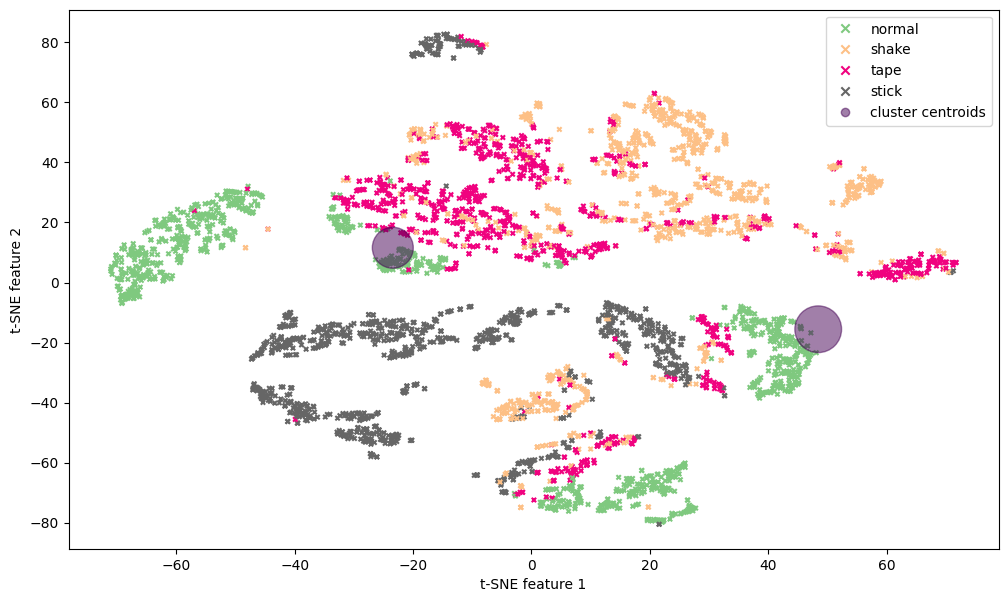

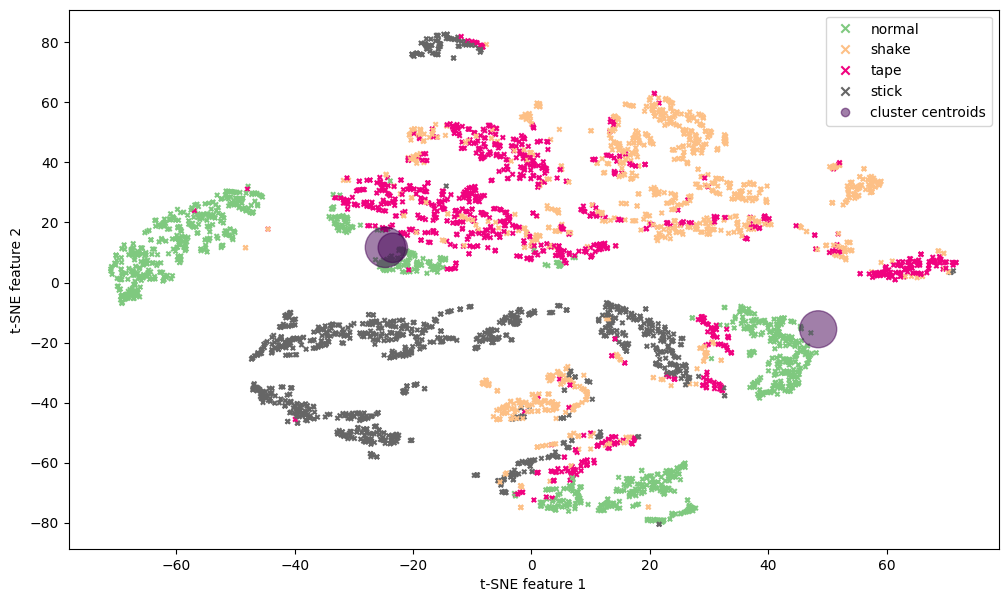

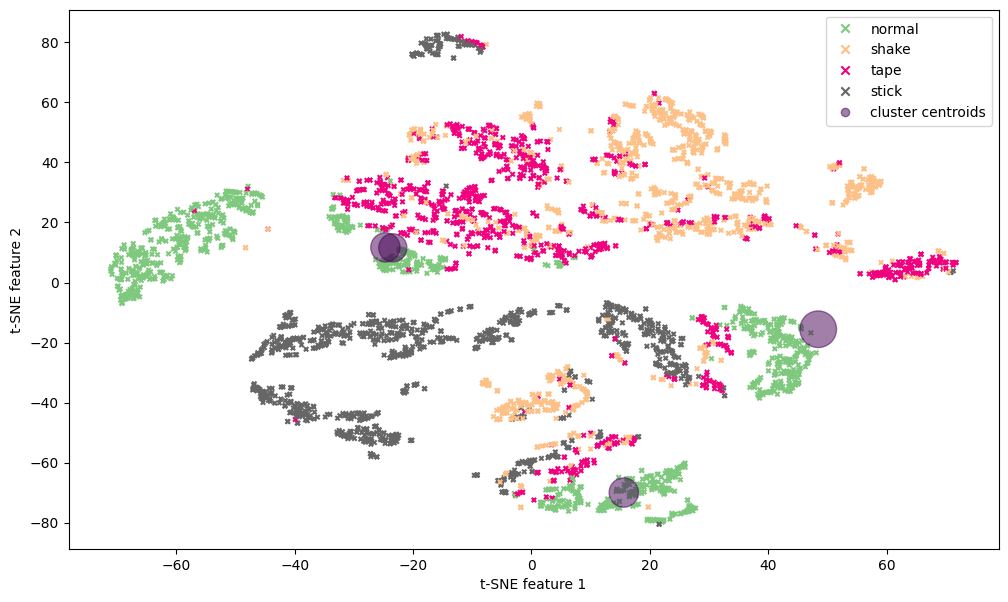

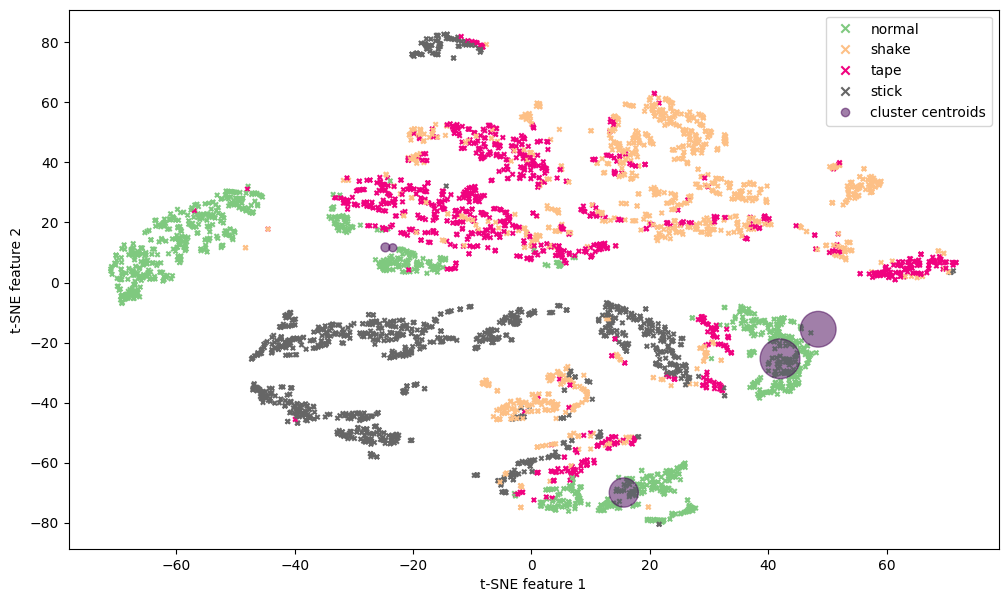

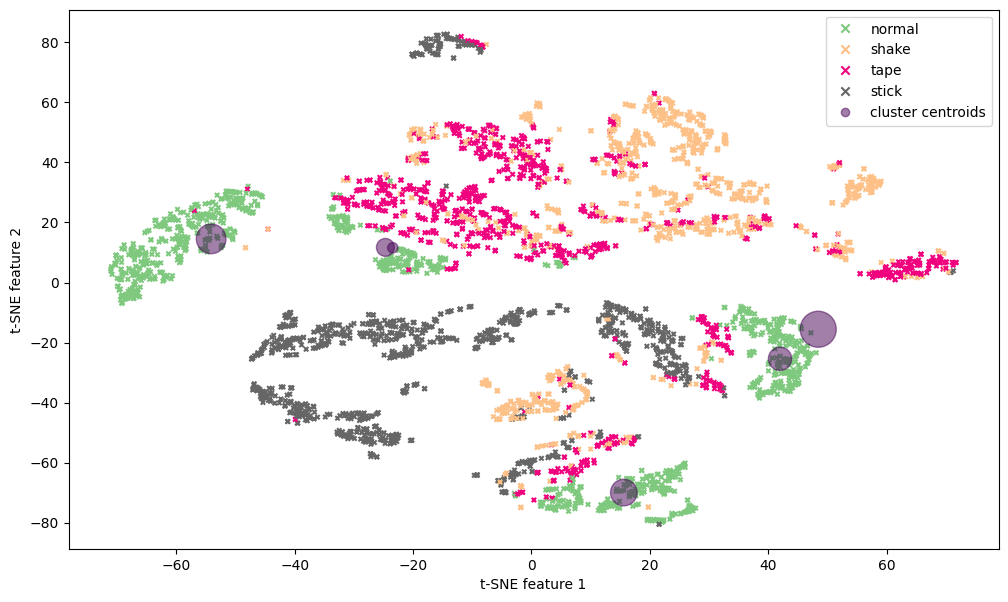

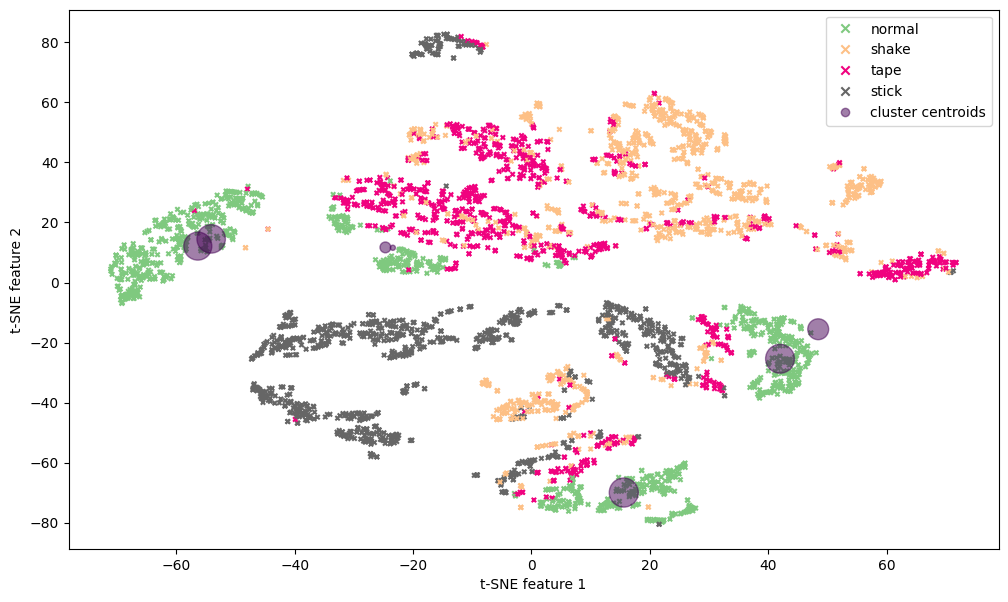

In [19]:
pp.style.use('default')
for c, w in zip(c_km, W_km):
    pp.figure(figsize=(12, 7))
    scatter_points = pp.scatter(xy_all[:-all_centroids.shape[0], 0], xy_all[:-all_centroids.shape[0], 1], c = Y_te, s = 10, cmap = 'Accent', marker='x')
    pp.xlabel('t-SNE feature 1',fontsize=10)
    pp.ylabel('t-SNE feature 2',fontsize=10)
    scatter_centroids = pp.scatter(c[:, 0], c[:, 1], c = np.zeros(c.shape[0]), s = w / np.sum(w) * 2000, alpha = 0.5);   
    pp.legend(
        scatter_points.legend_elements()[0] + scatter_centroids.legend_elements()[0], 
        labels + ['cluster centroids'], 
        loc = 0
    )
    pp.show()
    pp.close()

Calculate FPR, TPR, accuracy, and AUC for each number of clusters:

Number of clusters = 2, tpr = 82.233, fpr = 0.1, accuracy = 86.65, AUC = 0.89042
Number of clusters = 3, tpr = 84.5, fpr = 0.2, accuracy = 88.325, AUC = 0.8799
Number of clusters = 4, tpr = 86.0, fpr = 0.2, accuracy = 89.45, AUC = 0.88666
Number of clusters = 5, tpr = 90.3, fpr = 0.1, accuracy = 92.7, AUC = 0.92877
Number of clusters = 6, tpr = 91.0, fpr = 0.1, accuracy = 93.225, AUC = 0.93209
Number of clusters = 7, tpr = 90.667, fpr = 0.2, accuracy = 92.95, AUC = 0.90769


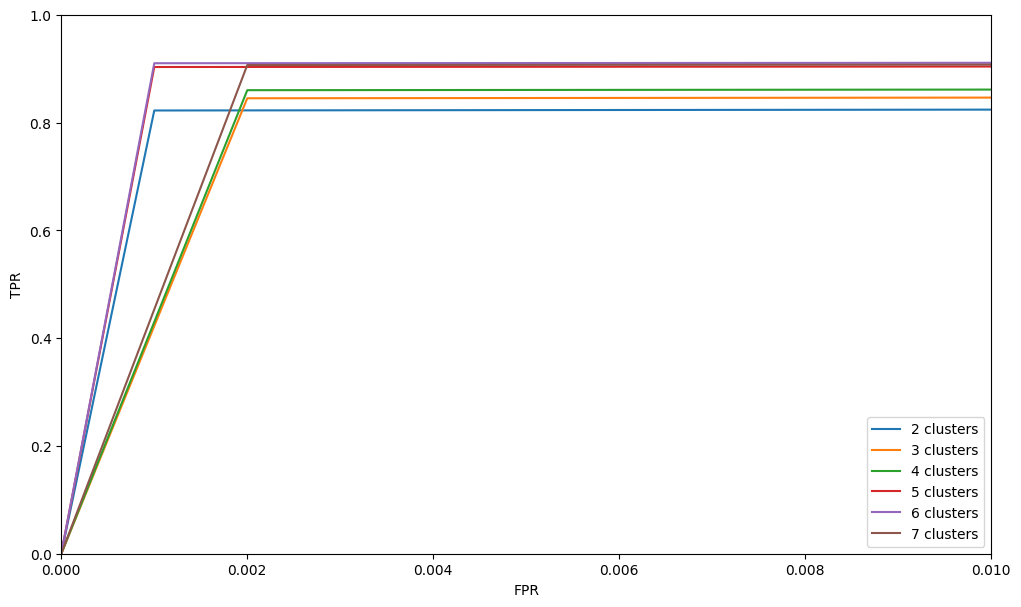

In [20]:
radiuses = []
fprs, tprs, accs, aucs = [], [], [], []

for ci, C in enumerate(C_km):
    
    C_ = (C - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)
    
    D_va = np.linalg.norm(E_va_[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_va = np.argmin(D_va, axis=1)
    dists_va = np.min(D_va, axis=1)
    
    D_te = np.linalg.norm(E_te_[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_te = np.argmin(D_te, axis=1)
    dists_te = np.min(D_te, axis=1)
       
    dist_thrs = np.zeros(C.shape[0])
    for k in range(C.shape[0]):
        idx = np.where(cl_labels_va == k)[0]
        dist_thrs[k] = np.max(dists_va[idx])
    radiuses.append(dist_thrs)
    pred_thrs = dist_thrs[cl_labels_te]
    predictions = np.zeros(nte)
    predictions[np.where(dists_te > pred_thrs)[0]] = 1
    fpr, tpr, thresholds = roc_curve(reals, predictions)    
    fprs.append(fpr)
    tprs.append(tpr)
    fpr_ = len(np.where((predictions == 1) & (reals == 0))[0]) / (1e-10 + len(np.where(reals == 0)[0])) * 100
    tpr_ = len(np.where((predictions == 1) & (reals == 1))[0]) / (1e-10 + len(np.where(reals == 1)[0])) * 100
    acc = len(np.where(predictions == reals)[0]) / nte * 100
    accs.append(acc)
    auc_score = roc_auc_score(reals, predictions, max_fpr=0.01)
    aucs.append(auc_score)
    print(f'Number of clusters = {C.shape[0]}, tpr = {tpr_:.5}, fpr = {fpr_:.5}, accuracy = {acc:.5}, AUC = {auc_score:.5}')
            
pp.figure(figsize=(12,7))
for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
    pp.plot(np.array(fpr), np.array(tpr), label=f'{C_km[i].shape[0]} {"cluster" if C_km[i].shape[0] == 1 else "clusters"}')
pp.xlim([0, 0.01])
pp.ylim([0, 1])
pp.xlabel('FPR')
pp.ylabel('TPR')
pp.legend()
pp.show()
pp.close()

Calculate MV and EM metrics:

In [21]:
em_rocs, mv_rocs = [], []
em_aucs, mv_aucs = [], []
ts = []

t_max = 0.99
n_generated = 100000
volume_support = (np.ones(E_va_.shape[1]) - np.zeros(E_va_.shape[1])).prod()
t = np.arange(0, 1 / volume_support, 0.001 / volume_support)
alpha_min = 0.99
alpha_max = 0.99999
axis_alpha = np.arange(alpha_min, alpha_max, 0.001)
X_unif = np.random.uniform(np.zeros(E_va_.shape[1]), np.ones(E_va_.shape[1]), size=(n_generated, E_va_.shape[1]))

for ci, C in enumerate(C_km):
    
    C_ = (C - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)

    D_test = np.linalg.norm(E_va_[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_test = np.argmin(D_test, axis=1)
    dists_test = np.min(D_test, axis=1)

    D_unif = np.linalg.norm(X_unif[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_unif = np.argmin(D_unif, axis=1)
    dists_unif = np.min(D_unif, axis=1)

    pred_thrs_test = radiuses[ci][cl_labels_test]
    predictions_test = (pred_thrs_test - dists_test) / (pred_thrs_test + 1e-10)

    pred_thrs_unif = radiuses[ci][cl_labels_unif]
    predictions_unif = (pred_thrs_unif - dists_unif) / (pred_thrs_unif + 1e-10)
    auc_em, em_roc, amax = em(t, t_max, volume_support, predictions_unif, predictions_test, n_generated)
    auc_mv, mv_roc = mv(axis_alpha, volume_support, predictions_unif, predictions_test, n_generated)
    mv_rocs.append(mv_roc)
    em_rocs.append(em_roc[:amax])
    mv_aucs.append(auc_mv)
    em_aucs.append(auc_em)
    ts.append(t[:amax])

Plot the metrics for different numbers of clusters:

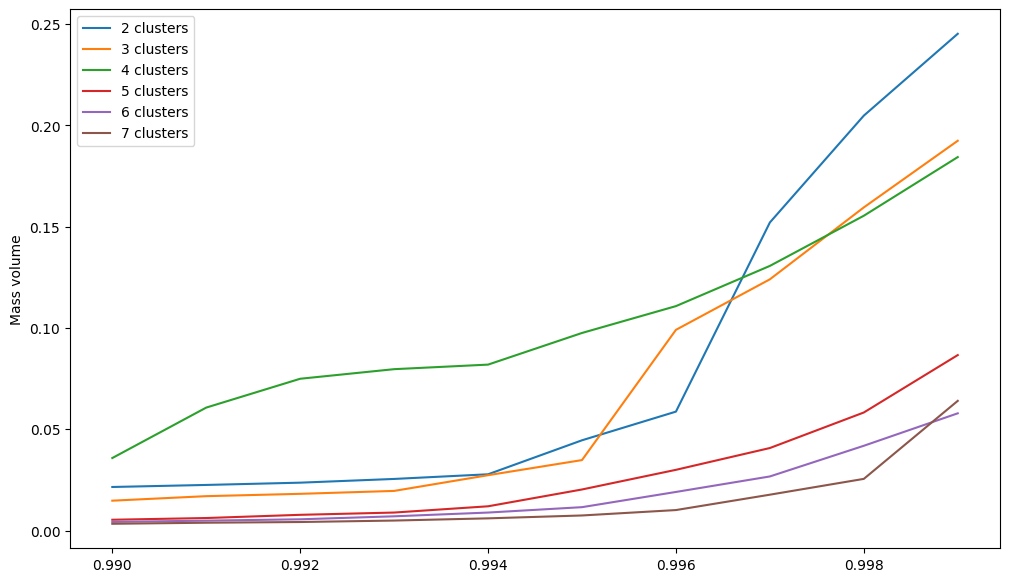

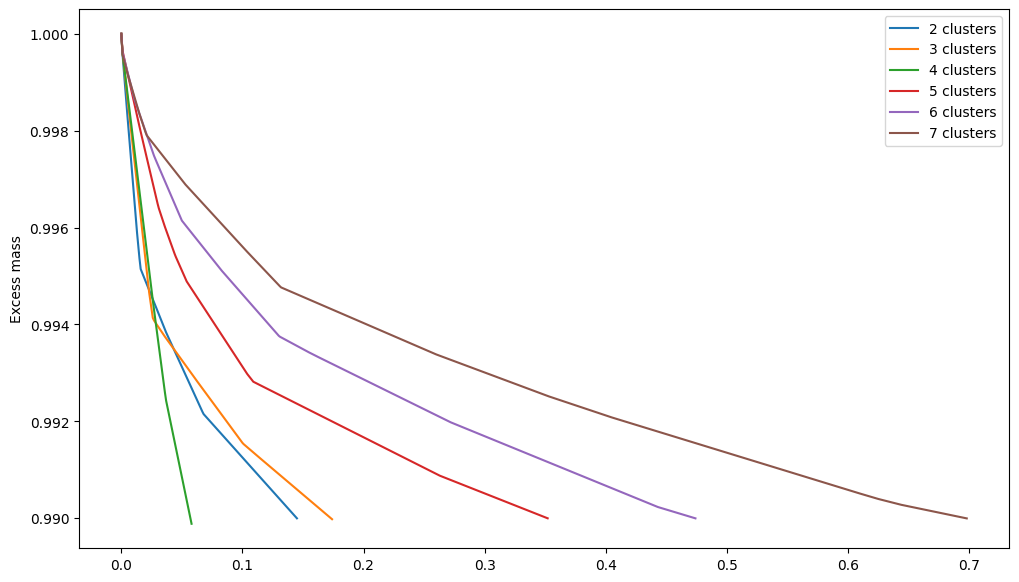

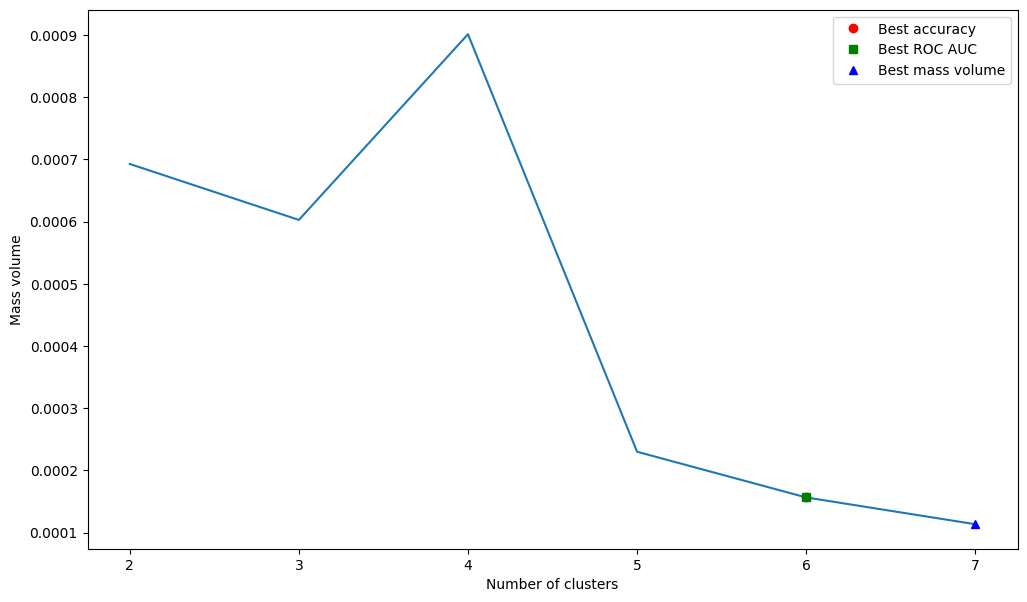

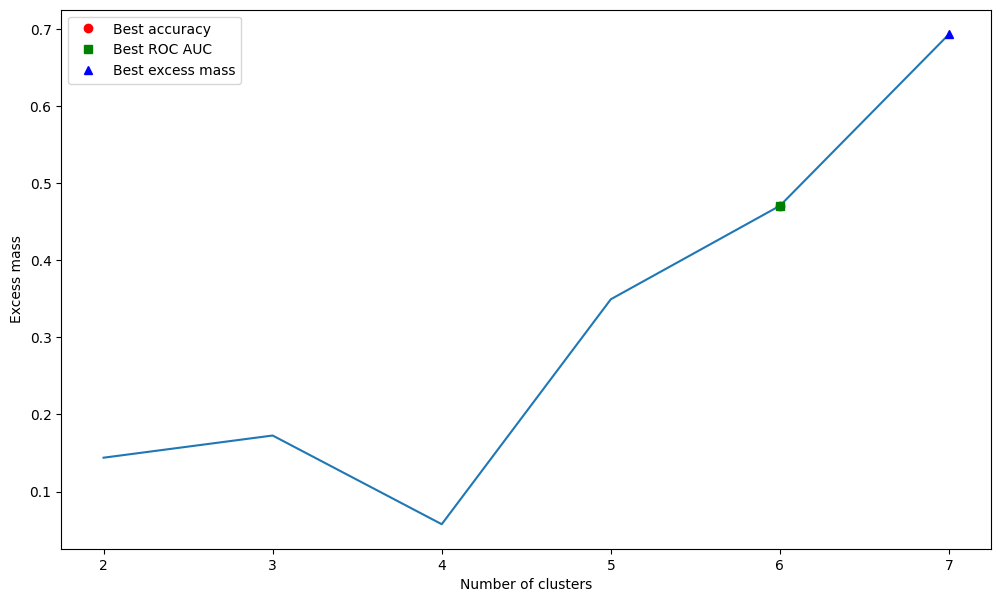

In [22]:
pp.figure(figsize=(12,7))
for i, mv_roc in enumerate(mv_rocs):
    pp.plot(axis_alpha, mv_roc, label=f'{C_km[i].shape[0]} {"cluster" if C_km[i].shape[0] == 1 else "clusters"}')
pp.ylabel('Mass volume')
pp.legend()
pp.show()
pp.close()

pp.figure(figsize=(12,7))
for i, (em_roc, t) in enumerate(zip(em_rocs, ts)):
    pp.plot(t, em_roc, label=f'{C_km[i].shape[0]} {"cluster" if C_km[i].shape[0] == 1 else "clusters"}')
pp.ylabel('Excess mass')
pp.legend()
pp.show()
pp.close()

x = np.array([c.shape[0] for c in C_km])
idx_best_acc = np.argmax(accs)
idx_best_auc = np.argmax(aucs)
idx_best_mv = np.argmin(mv_aucs)
idx_best_em = np.argmax(em_aucs)
for metric_name, metric, idx_best in zip(['Mass volume', 'Excess mass'], [np.array(mv_aucs), np.array(em_aucs)], [idx_best_mv, idx_best_em]):
    pp.figure(figsize=(12, 7))
    pp.plot(x, metric)
    pp.plot(x[idx_best_acc], metric[idx_best_acc], 'ro', label='Best accuracy')
    pp.plot(x[idx_best_auc], metric[idx_best_auc], 'gs', label='Best ROC AUC')
    pp.plot(x[idx_best], metric[idx_best], 'b^', label=f'Best {metric_name.lower()}')
    pp.legend()
    pp.xlabel('Number of clusters')
    pp.ylabel(metric_name)
    pp.show()
    pp.close()

<h3>CluStream k-means (streaming)</h3>

Clustering parameteres:

In [23]:
n_micro_clusters = 16  # the number of micro-clusters
micro_cluster_radius_alpha = 3  # micro-cluster radius parameter
n_clusters_min = 2  # the minimum number of clusters
n_clusters_max = 7  # the maximum number of clusters

Extracting micro-clusters:

In [ ]:
# init min and max values, micro-clusters and their radiuses

xmin = np.inf * np.ones(xdim)
xmax = -np.inf * np.ones(xdim)
C, R = [], []
cl_dist_min = 0

# the main clustering loop

for xi in range(ntr):
    
    # take a sample
    
    x = E_tr[xi, :].copy()
    
    # update min and max values
    
    xmin = np.min(np.vstack([xmin, x]), 0)
    xmax = np.max(np.vstack([xmax, x]), 0)
    
    # create initial micro-clsuter

    if len(C) < 2:
        C.append([1, x, x ** 2])
        R.append(0)
        #print(f'New micro-cluster {len(C)} has been created')
        
    # add sample to the existing framework
    
    else:
                        
        # update the minimal distance between micro-clusters
    
        D = np.zeros((len(C), len(C)))
        for i in range(len(C)):
            for j in range(len(C)):
                if i < j:
                    D[i, j] = np.sqrt(np.sum(((C[i][1] / C[i][0] - xmin)/(xmax - xmin + 1e-10) - (C[j][1] / C[j][0] - xmin)/(xmax - xmin + 1e-10))**2))
                else:
                    D[i, j] = np.inf
        cl_dist_min = np.min(D)
        i_dmin, j_dmin = np.where(D == cl_dist_min)
        i_dmin = i_dmin[0]
        j_dmin = j_dmin[0]
    
        # update micro-cluster radiuses
        
        for i in range(len(C)):
            if C[i][0] < 2:
                R[i] = cl_dist_min
            else:
                ls_ = (C[i][1] - C[i][0] * xmin) / (xmax - xmin + 1e-10)
                ss_ = (C[i][2] - 2 * C[i][1] * xmin  + C[i][0] * xmin ** 2) / ((xmax - xmin) ** 2 + 1e-10)
                R[i] = micro_cluster_radius_alpha * np.mean(np.sqrt(np.clip(ss_ / C[i][0] - (ls_ / C[i][0]) ** 2, 0, np.inf)))
                if R[i] == 0:
                    R[i] = cl_dist_min
        
        # calculate distances from the sample to the micro-clusters
       
        D = np.zeros(len(C))
        for i in range(len(C)):
            D[i] = np.sqrt(np.sum(((x - xmin)/(xmax - xmin + 1e-10) - (C[i][1] / C[i][0]  - xmin)/(xmax - xmin + 1e-10))**2))
        k = np.argmin(D)
                        
        if D[k] <= R[k]:
            
            # add sample to the existing micro-cluster
            
            C[k][0] += 1
            C[k][1] += x
            C[k][2] += x ** 2
            #print(f'Sample has been added to micro-cluster {k}')
        
        else:
            
            # merge the closest clusters
            
            if len(C) == n_micro_clusters:
                C[i_dmin][0] += C[j_dmin][0]
                C[i_dmin][1] += C[j_dmin][1]
                C[i_dmin][2] += C[j_dmin][2]
                C[j_dmin][0] = 1
                C[j_dmin][1] = x
                C[j_dmin][2] = x ** 2                
                #print(f'Micro-clusters {i_dmin} and {j_dmin} have been merged')
                                
            # create a new cluster
            
            else:            
                C.append([1, x, x ** 2])
                R.append(0)
                #print(f'New micro-cluster {len(C)} has been created')
        
W = np.hstack([c[0] for c in C])
C = np.vstack([c[1] / c[0] for c in C])

Clustering micro-clusters:

In [ ]:
# weighted k-means clustering

n_iters = 100
count = np.hstack([c[0] for c in C])
C_cs, W_cs = [], []

for n_clusters in range(n_clusters_min, n_clusters_max + 1):
    
    centroids = C[np.random.choice(range(C.shape[0]), n_clusters, replace=False), :]

    for i in range(n_iters):
        
        D = np.zeros((C.shape[0], centroids.shape[0]))
        for j in range(C.shape[0]):
            for k in range(centroids.shape[0]):
                D[j, k] = np.sum(((C[j, :] - xmin) / (xmax - xmin + 1e-10) - (centroids[k, :] - xmin) / (xmax - xmin + 1e-10)) ** 2)
        cl_labels = np.argmin(D, axis=1)
        
        centroids_new = []
        W_new = []
        
        for j in range(n_clusters):
            idx = np.where(cl_labels == j)[0]
            if len(idx) > 0:
                centroids_new.append(np.sum(count[idx, None] * C[idx, :], axis=0) / (np.sum(count[idx] + 1e-10)))
                W_new.append(np.sum(count[idx]))
            else:
                pass
                
        if np.array_equal(centroids, centroids_new):
            break 
                
        centroids = np.vstack(centroids_new)
        W = np.hstack(W_new)

    C_cs.append(centroids)
    W_cs.append(W)

Apply <a href=https://lvdmaaten.github.io/tsne/>t-SNE</a> for dimensionality reduction:

In [ ]:
all_centroids = np.vstack(C_cs)
X_plot = np.vstack([E_te, all_centroids])
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
xy_all = tsne.fit_transform(np.vstack(X_plot))
c_ = []
n = 0
for i in range(len(C_cs))[::-1]:
    ni = C_cs[i].shape[0]
    c_.append(xy_all[-n - ni : xy_all.shape[0] - n])
c_cs = c_[::-1]

Plot test data points from each class and the cluster centroids found:

In [ ]:
pp.style.use('default')
for c, w in zip(c_cs, W_cs):
    pp.figure(figsize=(12, 7))
    scatter_points = pp.scatter(xy_all[:-all_centroids.shape[0], 0], xy_all[:-all_centroids.shape[0], 1], c = Y_te, s = 10, cmap = 'Accent', marker='x')
    pp.xlabel('t-SNE feature 1',fontsize=10)
    pp.ylabel('t-SNE feature 2',fontsize=10)
    scatter_centroids = pp.scatter(c[:, 0], c[:, 1], c = np.zeros(c.shape[0]), s = w / np.sum(w) * 2000, alpha = 0.5);   
    pp.legend(
        scatter_points.legend_elements()[0] + scatter_centroids.legend_elements()[0], 
        labels + ['cluster centroids'], 
        loc = 0
    )
    pp.show()
    pp.close()

Calculate FPR, TPR, accuracy, and AUC for each number of clusters:

In [ ]:
radiuses = []
fprs, tprs, accs, aucs = [], [], [], []

for ci, C in enumerate(C_cs):
    
    C_ = (C - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)
    
    D_va = np.linalg.norm(E_va_[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_va = np.argmin(D_va, axis=1)
    dists_va = np.min(D_va, axis=1)
    
    D_te = np.linalg.norm(E_te_[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_te = np.argmin(D_te, axis=1)
    dists_te = np.min(D_te, axis=1)
       
    dist_thrs = np.zeros(C.shape[0])
    for k in range(C.shape[0]):
        idx = np.where(cl_labels_va == k)[0]
        if len(idx) > 0:
            dist_thrs[k] = np.max(dists_va[idx])
        else:
            dist_thrs[k] = 0
    radiuses.append(dist_thrs)
    pred_thrs = dist_thrs[cl_labels_te]
    predictions = np.zeros(nte)
    predictions[np.where(dists_te > pred_thrs)[0]] = 1
    fpr, tpr, thresholds = roc_curve(reals, predictions)    
    fprs.append(fpr)
    tprs.append(tpr)
    fpr_ = len(np.where((predictions == 1) & (reals == 0))[0]) / (1e-10 + len(np.where(reals == 0)[0])) * 100
    tpr_ = len(np.where((predictions == 1) & (reals == 1))[0]) / (1e-10 + len(np.where(reals == 1)[0])) * 100
    acc = len(np.where(predictions == reals)[0]) / nte * 100
    accs.append(acc)
    auc_score = roc_auc_score(reals, predictions, max_fpr=0.01)
    aucs.append(auc_score)
    print(f'Number of clusters = {C.shape[0]}, tpr = {tpr_:.5}, fpr = {fpr_:.5}, accuracy = {acc:.5}, AUC = {auc_score:.5}')
            
pp.figure(figsize=(12,7))
for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
    pp.plot(np.array(fpr), np.array(tpr), label=f'{C_cs[i].shape[0]} {"cluster" if C_cs[i].shape[0] == 1 else "clusters"}')
pp.xlim([0, 0.01])
pp.ylim([0, 1])
pp.xlabel('FPR')
pp.ylabel('TPR')
pp.legend()
pp.show()
pp.close()

Calculate MV and EM metrics:

In [ ]:
em_rocs, mv_rocs = [], []
em_aucs, mv_aucs = [], []
ts = []

t_max = 0.99
n_generated = 100000
volume_support = (np.ones(E_va_.shape[1]) - np.zeros(E_va_.shape[1])).prod()
t = np.arange(0, 1 / volume_support, 0.001 / volume_support)
alpha_min = 0.99
alpha_max = 0.99999
axis_alpha = np.arange(alpha_min, alpha_max, 0.001)
X_unif = np.random.uniform(np.zeros(E_va_.shape[1]), np.ones(E_va_.shape[1]), size=(n_generated, E_va_.shape[1]))

for ci, C in enumerate(C_cs):
    
    C_ = (C - xmin[None, :]) / (xmax[None, :] - xmin[None, :] + 1e-10)

    D_test = np.linalg.norm(E_va_[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_test = np.argmin(D_test, axis=1)
    dists_test = np.min(D_test, axis=1)

    D_unif = np.linalg.norm(X_unif[:, None, :] - C_[None, :, :], axis=-1)
    cl_labels_unif = np.argmin(D_unif, axis=1)
    dists_unif = np.min(D_unif, axis=1)

    pred_thrs_test = radiuses[ci][cl_labels_test]
    predictions_test = (pred_thrs_test - dists_test) / (pred_thrs_test + 1e-10)

    pred_thrs_unif = radiuses[ci][cl_labels_unif]
    predictions_unif = (pred_thrs_unif - dists_unif) / (pred_thrs_unif + 1e-10)
    auc_em, em_roc, amax = em(t, t_max, volume_support, predictions_unif, predictions_test, n_generated)
    auc_mv, mv_roc = mv(axis_alpha, volume_support, predictions_unif, predictions_test, n_generated)
    mv_rocs.append(mv_roc)
    em_rocs.append(em_roc[:amax])
    mv_aucs.append(auc_mv)
    em_aucs.append(auc_em)
    ts.append(t[:amax])

Plot the metrics for different numbers of clusters:

In [ ]:
pp.figure(figsize=(12,7))
for i, mv_roc in enumerate(mv_rocs):
    pp.plot(axis_alpha, mv_roc, label=f'{C_cs[i].shape[0]} {"cluster" if C_cs[i].shape[0] == 1 else "clusters"}')
pp.ylabel('Mass volume')
pp.legend()
pp.show()
pp.close()

pp.figure(figsize=(12,7))
for i, (em_roc, t) in enumerate(zip(em_rocs, ts)):
    pp.plot(t, em_roc, label=f'{C_cs[i].shape[0]} {"cluster" if C_cs[i].shape[0] == 1 else "clusters"}')
pp.ylabel('Excess mass')
pp.legend()
pp.show()
pp.close()

x = np.array([c.shape[0] for c in C_cs])
idx_best_acc = np.argmax(accs)
idx_best_auc = np.argmax(aucs)
idx_best_mv = np.argmin(mv_aucs)
idx_best_em = np.argmax(em_aucs)
for metric_name, metric, idx_best in zip(['Mass volume', 'Excess mass'], [np.array(mv_aucs), np.array(em_aucs)], [idx_best_mv, idx_best_em]):
    pp.figure(figsize=(12, 7))
    pp.plot(x, metric)
    pp.plot(x[idx_best_acc], metric[idx_best_acc], 'ro', label='Best accuracy')
    pp.plot(x[idx_best_auc], metric[idx_best_auc], 'gs', label='Best ROC AUC')
    pp.plot(x[idx_best], metric[idx_best], 'b^', label=f'Best {metric_name.lower()}')
    pp.legend()
    pp.xlabel('Number of clusters')
    pp.ylabel(metric_name)
    pp.show()
    pp.close()